## Decision Tree Model

### Imports and Utils

In [1]:
"""
Importing the necessary libraries
"""
import os
from time import time
import pickle
from typing import Union

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.special import xlogy
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

try:
    import plotly.express as px
except ModuleNotFoundError:
    %pip install plotly
    import plotly.express as px

try:
    from ucimlrepo import fetch_ucirepo
except ModuleNotFoundError:
    %pip install ucimlrepo
    from ucimlrepo import fetch_ucirepo

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
"""
Metric functions for the Model
"""

def accuracy(y_true: pd.Series, y_pred: pd.Series) -> float:
    """
    y_true: pd.Series: True labels
    y_pred: pd.Series: Predicted labels

    Returns: float: Accuracy
    """

    assert y_pred.size == y_true.size
    accuracy = np.isclose(y_true.values, y_pred.values, atol=0.01).mean()
    return accuracy

def Precision(y_true: pd.Series, y_pred: pd.Series, cls: Union[int, str]) -> float:
    """
    y_true: pd.Series: True labels
    y_pred: pd.Series: Predicted labels
    cls: Union[int, str]: Class to calculate precision for

    Returns: float: Precision
    """

    assert y_pred.shape == y_true.shape
    tp = ((np.isclose(y_pred, cls, atol=0.01)) & (np.isclose(y_true, cls, atol=0.01))).sum()
    fp = ((np.isclose(y_pred, cls, atol=0.01)) & ~(np.isclose(y_true, cls, atol=0.01))).sum()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    return precision

def Recall(y_true: pd.Series, y_pred: pd.Series, cls: Union[int, str]) -> float:
    """
    y_true: pd.Series: True labels
    y_pred: pd.Series: Predicted labels
    cls: Union[int, str]: Class to calculate recall for

    Returns: float: Recall
    """

    assert y_pred.shape == y_true.shape
    tp = ((np.isclose(y_pred, cls, atol=0.01)) & (np.isclose(y_true, cls, atol=0.01))).sum()
    fn = (~(np.isclose(y_pred, cls, atol=0.01)) & (np.isclose(y_true, cls, atol=0.01))).sum()
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    return recall

def F1_Score(y_true: pd.Series, y_pred: pd.Series, cls: Union[int, str]) -> float:
    """
    y_true: pd.Series: True labels
    y_pred: pd.Series: Predicted labels
    cls: Union[int, str]: Class to calculate F1 score for

    Returns: float: F1 score
    """

    assert y_pred.shape == y_true.shape
    prec = Precision(y_true, y_pred, cls)
    rec = Recall(y_true, y_pred, cls)
    f1 = 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0
    return f1

def MCC(y_true: pd.Series, y_pred: pd.Series, cls: Union[int, str]) -> float:
    """
    y_true: pd.Series: True labels
    y_pred: pd.Series: Predicted labels
    cls: Union[int, str]: Class to calculate Matthews Correlation Coefficient for

    Returns: float: Matthews Correlation Coefficient
    """

    assert y_pred.shape == y_true.shape
    tp = ((np.isclose(y_pred, cls, atol=0.01)) & (np.isclose(y_true, cls, atol=0.01))).sum()
    tn = (~(np.isclose(y_pred, cls, atol=0.01)) & ~(np.isclose(y_true, cls, atol=0.01))).sum()
    fp = ((np.isclose(y_pred, cls, atol=0.01)) & ~(np.isclose(y_true, cls, atol=0.01))).sum()
    fn = (~(np.isclose(y_pred, cls, atol=0.01)) & (np.isclose(y_true, cls, atol=0.01))).sum()

    mcc_n = (tp * tn) - (fp * fn)
    mcc_d = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    mcc = mcc_n / mcc_d if mcc_d > 0 else 0
    return mcc

In [3]:
"""
Utility functions for the Model
"""

def entropy(Y: pd.Series, bins: int = 50) -> float:
    """
    Y: pd.Series: Output values

    Returns: float: Entropy
    """

    if Y.empty:
        return 0

    # Y = pd.cut(Y, bins=bins)
    vals = Y.value_counts(normalize=True)
    return -np.sum(xlogy(vals, vals))

def gini_index(Y: pd.Series, bins: int = 50) -> float:
    """
    Y: pd.Series: Output values

    Returns: float: Gini Index
    """

    if Y.empty:
        return 0

    # Y = pd.cut(Y, bins=bins)
    vals = Y.value_counts(normalize=True)
    return 1 - np.sum(np.square(vals))

def information_gain(parent: pd.Series, left: pd.Series, right: pd.Series, criterion: str) -> float:
    """
    parent: pd.Series: Input parent dataset.
    left: pd.Series: Subset of the parent dataset.
    right: pd.Series: Subset of the parent dataset.

    Returns: float: Information gain.
    """
    FMap = {"entropy": entropy, "gini": gini_index}

    # calculate parent and child entropy
    before_entropy = FMap[criterion](parent)
    after_entropy = (len(left) / len(parent)) * FMap[criterion](left) + (len(right) / len(parent)) * FMap[criterion](right)
        
    # calculate information gain 
    information_gain = before_entropy - after_entropy
    return information_gain

def best_split(dataset: pd.DataFrame, num_samples: int, num_features: int, criterion: str) -> dict:
    """
    dataset: pd.DataFrame: The dataset to split.
    num_samples: int: The number of samples in the dataset.
    num_features: int: The number of features in the dataset.

    Returns: dict: A dictionary with the best split.
    """
        
    # Find the best split
    best_split = {'gain': -1, 'feature': None, 'threshold': None, "left_dataset": None, "right_dataset": None}
    for feature_index in range(num_features):
        feature_values = dataset.iloc[:, feature_index]
        thresholds = np.unique(feature_values)
        for threshold in thresholds:
            left_dataset, right_dataset = split_data(dataset, feature_index, threshold)
            y, left_y, right_y = dataset.iloc[:, -1], left_dataset.iloc[:, -1], right_dataset.iloc[:, -1]
            gain = information_gain(y, left_y, right_y, criterion)
            if gain > best_split["gain"]:
                best_split["gain"] = gain
                best_split["feature"] = feature_index
                best_split["threshold"] = threshold
                best_split["left_dataset"] = left_dataset
                best_split["right_dataset"] = right_dataset
    return best_split

def split_data(dataset: pd.DataFrame, feature: int, threshold: float) -> tuple:
    """
    dataset: pd.DataFrame: Input dataset.
    feature: int: Index of the feature to be split on.
    threshold: float: Threshold value to split the feature on.

    Returns:
        left_dataset: pd.DataFrame: Subset of the dataset.
        right_dataset: pd.DataFrame: Subset of the dataset.
    """
    
    # Create mask of the dataset using threshold
    mask = (dataset.iloc[:, feature] <= threshold)

    # Mask the dataset
    left_dataset = dataset[mask]
    right_dataset = dataset[~mask]
    return left_dataset, right_dataset

### Dataset Loading and Preprocessing

In [4]:
target = 'Diagnosis'

# Dataset 1 Auto MPG
'''
# Reading the data
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
dataset = pd.read_csv(url, delim_whitespace=True, header=None,names=["mpg", "cylinders", "displacement", "horsepower", "weight", "acceleration", "model year", "origin", "car name"])

# Cleaning the data
dataset = dataset.drop(columns=["car name", "origin"]).replace('?', np.nan).dropna()
dataset['horsepower'] = pd.to_numeric(dataset['horsepower'])
dataset = pd.concat([dataset.drop(columns=[target]), dataset[target]], axis=1)

# Print the first few records
print(dataset.head())

# Print the size of the dataset
print("size of the dataset: ", dataset.shape)
'''

# Dataset 2 Breast Cancer
# '''
dataset = fetch_ucirepo(id=17)
dataset = pd.concat([dataset.data.features, dataset.data.targets], axis=1)

# Cleaning the data
dataset = dataset.dropna()
dataset[target] = (dataset[target] == 'M').astype(int)

# Print the first few records
print(dataset.head())

# Print the size of the dataset
print("size of the dataset: ", dataset.shape)
# '''

   radius1  texture1  perimeter1   area1  smoothness1  compactness1  \
0    17.99     10.38      122.80  1001.0      0.11840       0.27760   
1    20.57     17.77      132.90  1326.0      0.08474       0.07864   
2    19.69     21.25      130.00  1203.0      0.10960       0.15990   
3    11.42     20.38       77.58   386.1      0.14250       0.28390   
4    20.29     14.34      135.10  1297.0      0.10030       0.13280   

   concavity1  concave_points1  symmetry1  fractal_dimension1  ...  texture3  \
0      0.3001          0.14710     0.2419             0.07871  ...     17.33   
1      0.0869          0.07017     0.1812             0.05667  ...     23.41   
2      0.1974          0.12790     0.2069             0.05999  ...     25.53   
3      0.2414          0.10520     0.2597             0.09744  ...     26.50   
4      0.1980          0.10430     0.1809             0.05883  ...     16.67   

   perimeter3   area3  smoothness3  compactness3  concavity3  concave_points3  \
0      184.

In [5]:
# Data visualization
px.pie(dataset, target, color=target, color_discrete_sequence=["#ba1656","#381a40"], title='Data Distribution')

In [6]:
for column in dataset.drop(target,axis=1).columns[:5]:
    fig = px.density_heatmap(dataset, x=column, y=target, color_continuous_scale='magma_r')
    fig.show()

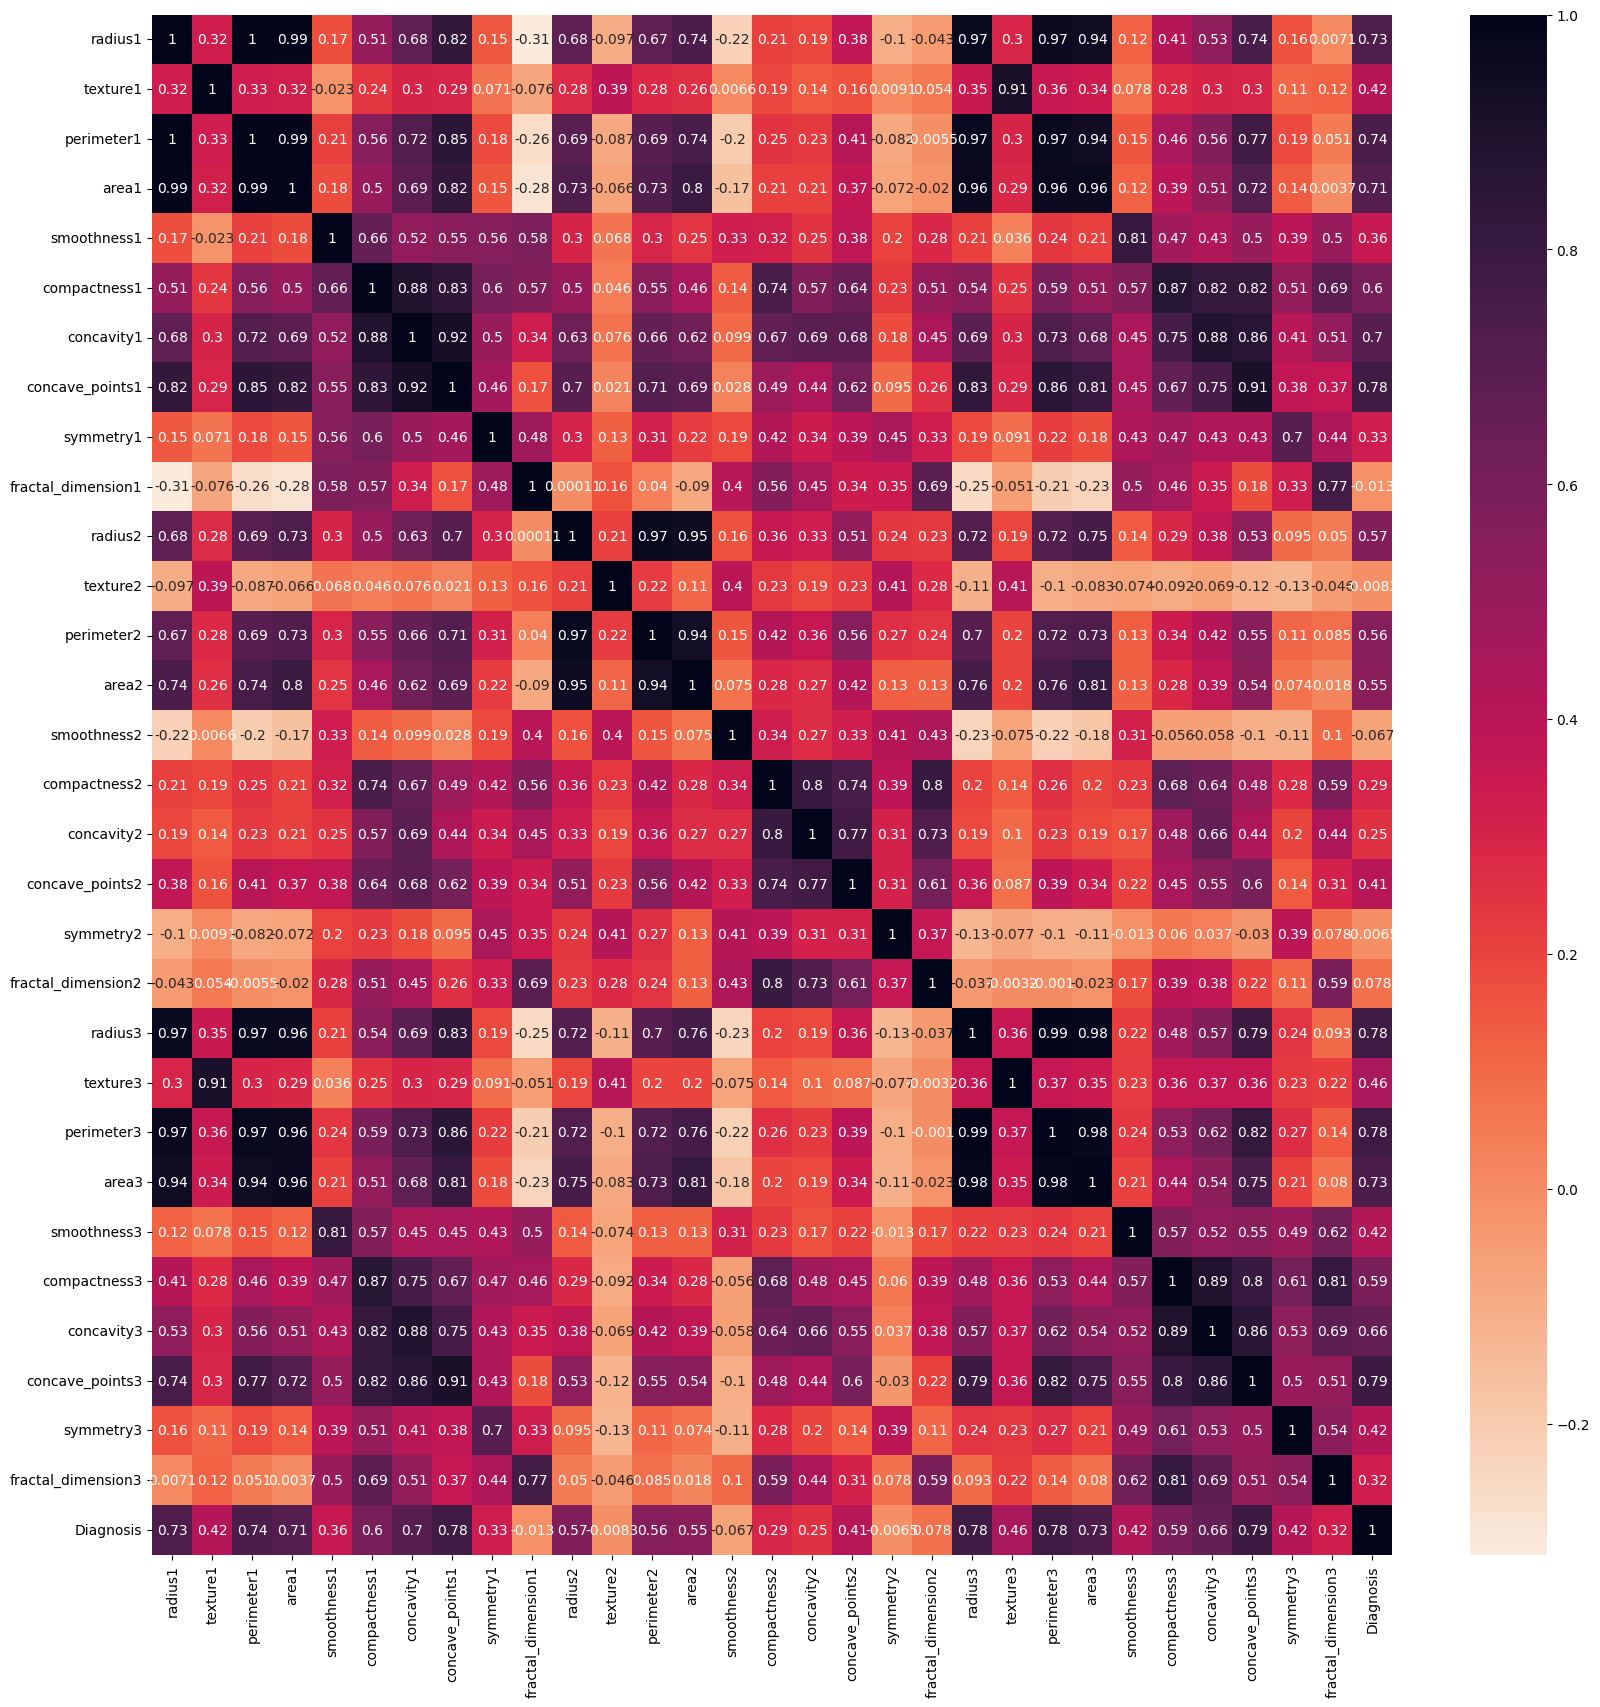

In [7]:
# Checking coorelation within the dataset
dataset_corr = dataset.corr()
plt.figure(figsize=(20,20))
sns.heatmap(dataset_corr, cmap='rocket_r',annot=True)
plt.show()

In [8]:
# Feature selection
threshold = 0.35
target_corr = abs(dataset_corr.iloc[:, -1])
features = target_corr[target_corr > threshold].index

# Display the relevant features
dataset = dataset[features]
print("Relevant Features:\n", features.values)

Relevant Features:
 ['radius1' 'texture1' 'perimeter1' 'area1' 'smoothness1' 'compactness1'
 'concavity1' 'concave_points1' 'radius2' 'perimeter2' 'area2'
 'concave_points2' 'radius3' 'texture3' 'perimeter3' 'area3' 'smoothness3'
 'compactness3' 'concavity3' 'concave_points3' 'symmetry3' 'Diagnosis']


In [9]:
# Extract X and Y from dataset
X = dataset.iloc[:, :-1]
Y = dataset.iloc[:, -1]

# Split the dataset into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, random_state=42)

# Print the first few records
print(f'Feature Train Dataset:\n{X_train.head()}\nsize: {X_train.shape}\n')
print(f'Target Train Dataset:\n{Y_train.head()}\nsize: {Y_train.shape}\n')
print(f'Feature Test Dataset:\n{X_test.head()}\nsize: {X_test.shape}\n')
print(f'Target Test Dataset:\n{Y_test.head()}\nsize: {Y_test.shape}\n')

Feature Train Dataset:
     radius1  texture1  perimeter1   area1  smoothness1  compactness1  \
68     9.029     17.33       58.79   250.5      0.10660       0.14130   
181   21.090     26.57      142.70  1311.0      0.11410       0.28320   
63     9.173     13.86       59.20   260.9      0.07721       0.08751   
248   10.650     25.22       68.01   347.0      0.09657       0.07234   
60    10.170     14.88       64.55   311.9      0.11340       0.08061   

     concavity1  concave_points1  radius2  perimeter2  ...  concave_points2  \
68      0.31300          0.04375   0.3274       1.885  ...         0.033220   
181     0.24870          0.14960   0.6298       4.414  ...         0.015670   
63      0.05988          0.02180   0.4098       2.608  ...         0.015600   
248     0.02379          0.01615   0.2497       1.497  ...         0.006245   
60      0.01084          0.01290   0.5158       3.312  ...         0.008193   

     radius3  texture3  perimeter3   area3  smoothness3  compac

### Model Creation and Training

In [10]:
class Node():
    """
    A class representing a node in a decision tree.
    """

    def __init__(self, feature=None, threshold=None, left=None, right=None, gain=None, value=None):
        """
        feature: string: The feature used for splitting at this node.
        threshold: List of float: The threshold used for splitting at this node.
        left: Node: Pointer to the left Node.
        Right: Node: Pointer to the Right Node.
        gain: float: The gain of the split.
        value: float: predicted value at this node.
        """

        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.gain = gain
        self.value = value

In [11]:
class DecisionTree():
    """
    A decision tree classifier.
    """

    def __init__(self, type: str, criterion: str = 'entropy', min_samples: int = 2, max_depth: int = 2):
        """
        Constructor for DecisionTree class.

        type: string: The type of the decision tree.
        criterion: string: The criterion used to split nodes.
        min_samples: int: Minimum number of samples at leaf node.
        max_depth: int: Maximum depth of the decision tree.
        """

        if type not in ["classification", "regression"]:
            raise ValueError("type should be either 'classification' or 'regression'")
        
        if criterion not in ["entropy", "gini"]:
            raise ValueError("criterion should be either 'entropy' or 'gini'")
        
        self.type = type
        self.criterion = criterion
        self.min_samples = min_samples
        self.max_depth = max_depth
    
    def build_tree(self, dataset: pd.DataFrame, current_depth: int = 0):
        """
        dataset: pd.DataFrame: The dataset to build the tree.
        current_depth: int: The current depth of the tree.

        Returns: Node: The root node of the decision tree.
        """
        
        # split the dataset into X, y values
        X, y = dataset.iloc[:, :-1], dataset.iloc[:, -1]
        n_samples, n_features = X.shape
        
        # Terminating conditions
        if n_samples >= self.min_samples and current_depth <= self.max_depth:
            best_split_values = best_split(dataset, n_samples, n_features, self.criterion)
            left_node = self.build_tree(best_split_values["left_dataset"], current_depth + 1)
            right_node = self.build_tree(best_split_values["right_dataset"], current_depth + 1)

            return Node(best_split_values["feature"], best_split_values["threshold"], left_node, right_node, best_split_values["gain"])

        # compute leaf node value
        if self.type == "classification":
            leaf_value = y.mode()[0]
        elif self.type == "regression":
            leaf_value = y.median()
        
        return Node(value=leaf_value)
    
    def fit(self, X: pd.DataFrame, y: pd.Series):
        """
        X: pd.DataFrame: The feature datset.
        y: pd.Series: The target values.
        """
        
        dataset = pd.concat([X, y], axis=1) 
        self.root = self.build_tree(dataset)

    def predict(self, X: pd.DataFrame):
        """
        X: pd.DataFrame: The feature matrix to make predictions for.

        Returns:
        list: A list of predicted class labels.
        """
        
        predictions = X.apply(self.traverse_tree, axis=1, args=(self.root,))
        return predictions
    
    def traverse_tree(self, X: pd.Series, node: Node):
        """
        X: pd.Series: The feature vector to predict the target value for.
        node: Node: The current node being evaluated.

        Returns: float: The predicted target value.
        """
        
        if node.value is not None: # if the node is a leaf node
            return node.value
        else: # if the node is not a leaf node
            feature = X.iloc[node.feature]
            if feature <= node.threshold:
                return self.traverse_tree(X, node.left)
            else:
                return self.traverse_tree(X, node.right)
            
    def plot_tree(self, node: Node = None, depth: int = 0):
        """
        Plot the decision tree.

        node: Node: The current node being evaluated.
        depth: int: The current depth of the tree.
        """
        
        if node is None:
            node = self.root

        if node.value is not None:
            print(f"{4*depth * '  '}Predict: {round(node.value, 3)}")
        else:
            print(f"{4*depth * '  '}?(column {node.feature} <= {round(node.threshold, 3)})")
            self.plot_tree(node.left, depth + 1)
            self.plot_tree(node.right, depth + 1)

In [12]:
# Defining the model for Decision Tree
# model = DecisionTree(type='regression', criterion='entropy' , min_samples=10, max_depth=3)
model = DecisionTree(type='classification', criterion='entropy' , min_samples=10, max_depth=3)

In [13]:
# Training the model
model.fit(X_train, Y_train)

# Calculating the metrics
Y_pred = model.predict(X_train)
print(f"Train MSE: {mean_squared_error(Y_train, Y_pred)}")

Train MSE: 0.01098901098901099


In [14]:
# Plotting the Decision Tree
model.plot_tree()

?(column 7 <= 0.051)
        ?(column 12 <= 16.77)
                ?(column 8 <= 0.606)
                        ?(column 13 <= 30.04)
                                Predict: 0
                                Predict: 0
                        Predict: 1
                ?(column 1 <= 15.7)
                        Predict: 0
                        ?(column 11 <= 0.01)
                                Predict: 1
                                Predict: 0
        ?(column 14 <= 114.3)
                ?(column 13 <= 25.47)
                        ?(column 19 <= 0.157)
                                Predict: 0
                                Predict: 1
                        ?(column 9 <= 1.513)
                                Predict: 0
                                Predict: 1
                ?(column 0 <= 11.84)
                        Predict: 1
                        ?(column 0 <= 14.19)
                                Predict: 1
                                Predict: 1


### Testing and Plotting

In [15]:
# Predicting the values
Y_pred = model.predict(X_test)

# Calculating the metrics
print(f'Test MSE: {mean_squared_error(Y_test, Y_pred)}')

Test MSE: 0.06140350877192982


In [16]:
# Specify the directory you want to save in
directory = "Models"
os.makedirs(directory, exist_ok=True)

# Train the model with different hyperparameters
type = 'classification'
n_classes = np.unique(Y_test)
Metrics = {}
for depth in range(0, 5):
    print(f"Decision Tree for max depth of {depth}")

    # Defining the model for Decision Tree
    model = DecisionTree(type=type, criterion='entropy' , min_samples=10, max_depth=depth)
    start = time()
    model.fit(X_train, Y_train)
    end = time()
    train_time = end - start

    # Calculating the metrics
    Y_pred = model.predict(X_train)
    train_mse = mean_squared_error(Y_train, Y_pred)
    if type == 'classification':
        accuracy_train = accuracy(Y_train, Y_pred)
        print(f"Train Accuracy: {round(100*accuracy_train, 3)}")
    start = time()
    Y_pred = model.predict(X_test)
    end = time()
    predict_time = end - start
    test_mse = mean_squared_error(Y_test, Y_pred)
    if type == 'classification':
        accuracy_test = accuracy(Y_test, Y_pred)
        f1score = 0
        mcc = 0
        for i in range(len(n_classes)):
            f1score += F1_Score(Y_test, Y_pred, n_classes[i])
            mcc += MCC(Y_test, Y_pred, n_classes[i])
        f1score /= len(n_classes)
        mcc /= len(n_classes)
        print(f"Test Accuracy: {round(100*accuracy_test, 3)}")
        print(f"F1 Score: {round(f1score, 3)}")
        print(f"Matthews Correlation Coefficient: {round(mcc, 3)}")

    # Storing the metrics
    Metrics[depth] = {"Train MSE": train_mse, "Test MSE": test_mse, "Train Time": train_time, "Predict Time": predict_time}
    print(f"Train MSE: {round(train_mse, 3)}")
    print(f"Test MSE: {round(test_mse, 3)}")
    if type == 'classification':
        Metrics[depth]["Train Accuracy"] = accuracy_train
        Metrics[depth]["Test Accuracy"] = accuracy_test
        Metrics[depth]["F1 Score"] = f1score
        Metrics[depth]["MCC"] = mcc

    # Saving the model
    filepath = os.path.join(directory, f"DTree_Entropy_{depth}.pkl")
    with open(filepath, "wb") as file:
        pickle.dump(model, file)
    print("\n------------------------------------------------------------\n")

Metrics = pd.DataFrame(Metrics).T


Decision Tree for max depth of 0
Train Accuracy: 92.088
Test Accuracy: 88.596
F1 Score: 0.881
Matthews Correlation Coefficient: 0.766
Train MSE: 0.079
Test MSE: 0.114

------------------------------------------------------------

Decision Tree for max depth of 1
Train Accuracy: 92.747
Test Accuracy: 90.351
F1 Score: 0.9
Matthews Correlation Coefficient: 0.808
Train MSE: 0.073
Test MSE: 0.096

------------------------------------------------------------

Decision Tree for max depth of 2
Train Accuracy: 98.022
Test Accuracy: 94.737
F1 Score: 0.943
Matthews Correlation Coefficient: 0.888
Train MSE: 0.02
Test MSE: 0.053

------------------------------------------------------------

Decision Tree for max depth of 3
Train Accuracy: 98.901
Test Accuracy: 93.86
F1 Score: 0.934
Matthews Correlation Coefficient: 0.869
Train MSE: 0.011
Test MSE: 0.061

------------------------------------------------------------

Decision Tree for max depth of 4
Train Accuracy: 98.901
Test Accuracy: 93.86
F1 Scor

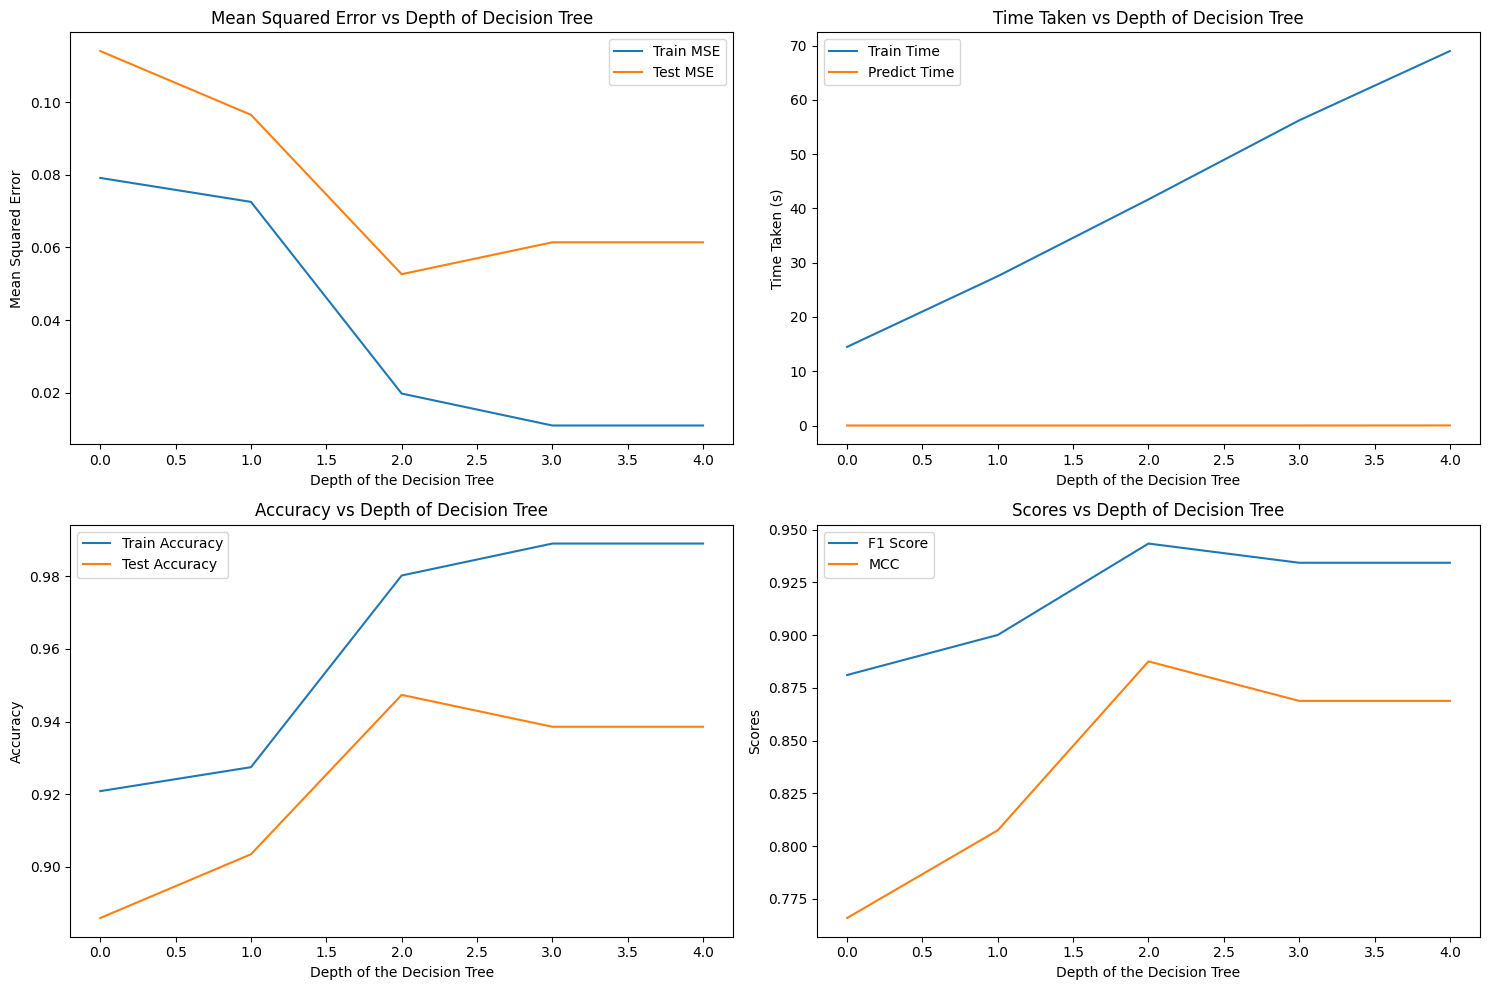

In [19]:
# Plotting the metrics
if type == 'classification':
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    Metrics.iloc[:, :2].plot(ax=axs[0, 0])
    axs[0, 0].set_xlabel('Depth of the Decision Tree')
    axs[0, 0].set_ylabel('Mean Squared Error')
    axs[0, 0].set_title('Mean Squared Error vs Depth of Decision Tree')

    Metrics.iloc[:, 2:4].plot(ax=axs[0, 1])
    axs[0, 1].set_xlabel('Depth of the Decision Tree')
    axs[0, 1].set_ylabel('Time Taken (s)')
    axs[0, 1].set_title('Time Taken vs Depth of Decision Tree')

    Metrics.iloc[:, 4:6].plot(ax=axs[1, 0])
    axs[1, 0].set_xlabel('Depth of the Decision Tree')
    axs[1, 0].set_ylabel('Accuracy')
    axs[1, 0].set_title('Accuracy vs Depth of Decision Tree')

    Metrics.iloc[:, 6:].plot(ax=axs[1, 1])
    axs[1, 1].set_xlabel('Depth of the Decision Tree')
    axs[1, 1].set_ylabel('Scores')
    axs[1, 1].set_title('Scores vs Depth of Decision Tree')

elif type == 'regression':
    fig, axs = plt.subplots(1, 2, figsize=(20, 8))

    Metrics.iloc[:, :2].plot(ax=axs[0])
    axs[0].set_xlabel('Depth of the Decision Tree')
    axs[0].set_ylabel('Mean Squared Error')
    axs[0].set_title('Mean Squared Error vs Depth of Decision Tree')

    Metrics.iloc[:, 2:4].plot(ax=axs[1])
    axs[1].set_xlabel('Depth of the Decision Tree')
    axs[1].set_ylabel('Time Taken (s)')
    axs[1].set_title('Time Taken vs Depth of Decision Tree')
    
plt.tight_layout()
plt.show()

In [21]:
# Specify the directory you want to save in
directory = "Models"
os.makedirs(directory, exist_ok=True)

# Train the model with different hyperparameters
type = 'classification'
n_classes = np.unique(Y_test)
Metrics = {}
for depth in range(0, 5):
    print(f"Decision Tree for max depth of {depth}")

    # Defining the model for Decision Tree
    model = DecisionTree(type=type, criterion='gini' , min_samples=10, max_depth=depth)
    start = time()
    model.fit(X_train, Y_train)
    end = time()
    train_time = end - start

    # Calculating the metrics
    Y_pred = model.predict(X_train)
    train_mse = mean_squared_error(Y_train, Y_pred)
    if type == 'classification':
        accuracy_train = accuracy(Y_train, Y_pred)
        print(f"Train Accuracy: {round(100*accuracy_train, 3)}")
    start = time()
    Y_pred = model.predict(X_test)
    end = time()
    predict_time = end - start
    test_mse = mean_squared_error(Y_test, Y_pred)
    if type == 'classification':
        accuracy_test = accuracy(Y_test, Y_pred)
        f1score = 0
        mcc = 0
        for i in range(len(n_classes)):
            f1score += F1_Score(Y_test, Y_pred, n_classes[i])
            mcc += MCC(Y_test, Y_pred, n_classes[i])
        f1score /= len(n_classes)
        mcc /= len(n_classes)
        print(f"Test Accuracy: {round(100*accuracy_test, 3)}")
        print(f"F1 Score: {round(f1score, 3)}")
        print(f"Matthews Correlation Coefficient: {round(mcc, 3)}")

    # Storing the metrics
    Metrics[depth] = {"Train MSE": train_mse, "Test MSE": test_mse, "Train Time": train_time, "Predict Time": predict_time}
    print(f"Train MSE: {round(train_mse, 3)}")
    print(f"Test MSE: {round(test_mse, 3)}")
    if type == 'classification':
        Metrics[depth]["Train Accuracy"] = accuracy_train
        Metrics[depth]["Test Accuracy"] = accuracy_test
        Metrics[depth]["F1 Score"] = f1score
        Metrics[depth]["MCC"] = mcc

    # Saving the model
    filepath = os.path.join(directory, f"DTree_Gini_{depth}.pkl")
    with open(filepath, "wb") as file:
        pickle.dump(model, file)
    print("\n------------------------------------------------------------\n")

Metrics = pd.DataFrame(Metrics).T

Decision Tree for max depth of 0
Train Accuracy: 92.088
Test Accuracy: 88.596
F1 Score: 0.881
Matthews Correlation Coefficient: 0.766
Train MSE: 0.079
Test MSE: 0.114

------------------------------------------------------------

Decision Tree for max depth of 1
Train Accuracy: 92.967
Test Accuracy: 92.982
F1 Score: 0.924
Matthews Correlation Coefficient: 0.85
Train MSE: 0.07
Test MSE: 0.07

------------------------------------------------------------

Decision Tree for max depth of 2
Train Accuracy: 97.582
Test Accuracy: 93.86
F1 Score: 0.934
Matthews Correlation Coefficient: 0.869
Train MSE: 0.024
Test MSE: 0.061

------------------------------------------------------------

Decision Tree for max depth of 3
Train Accuracy: 99.341
Test Accuracy: 92.982
F1 Score: 0.926
Matthews Correlation Coefficient: 0.853
Train MSE: 0.007
Test MSE: 0.07

------------------------------------------------------------

Decision Tree for max depth of 4
Train Accuracy: 99.341
Test Accuracy: 92.982
F1 Scor

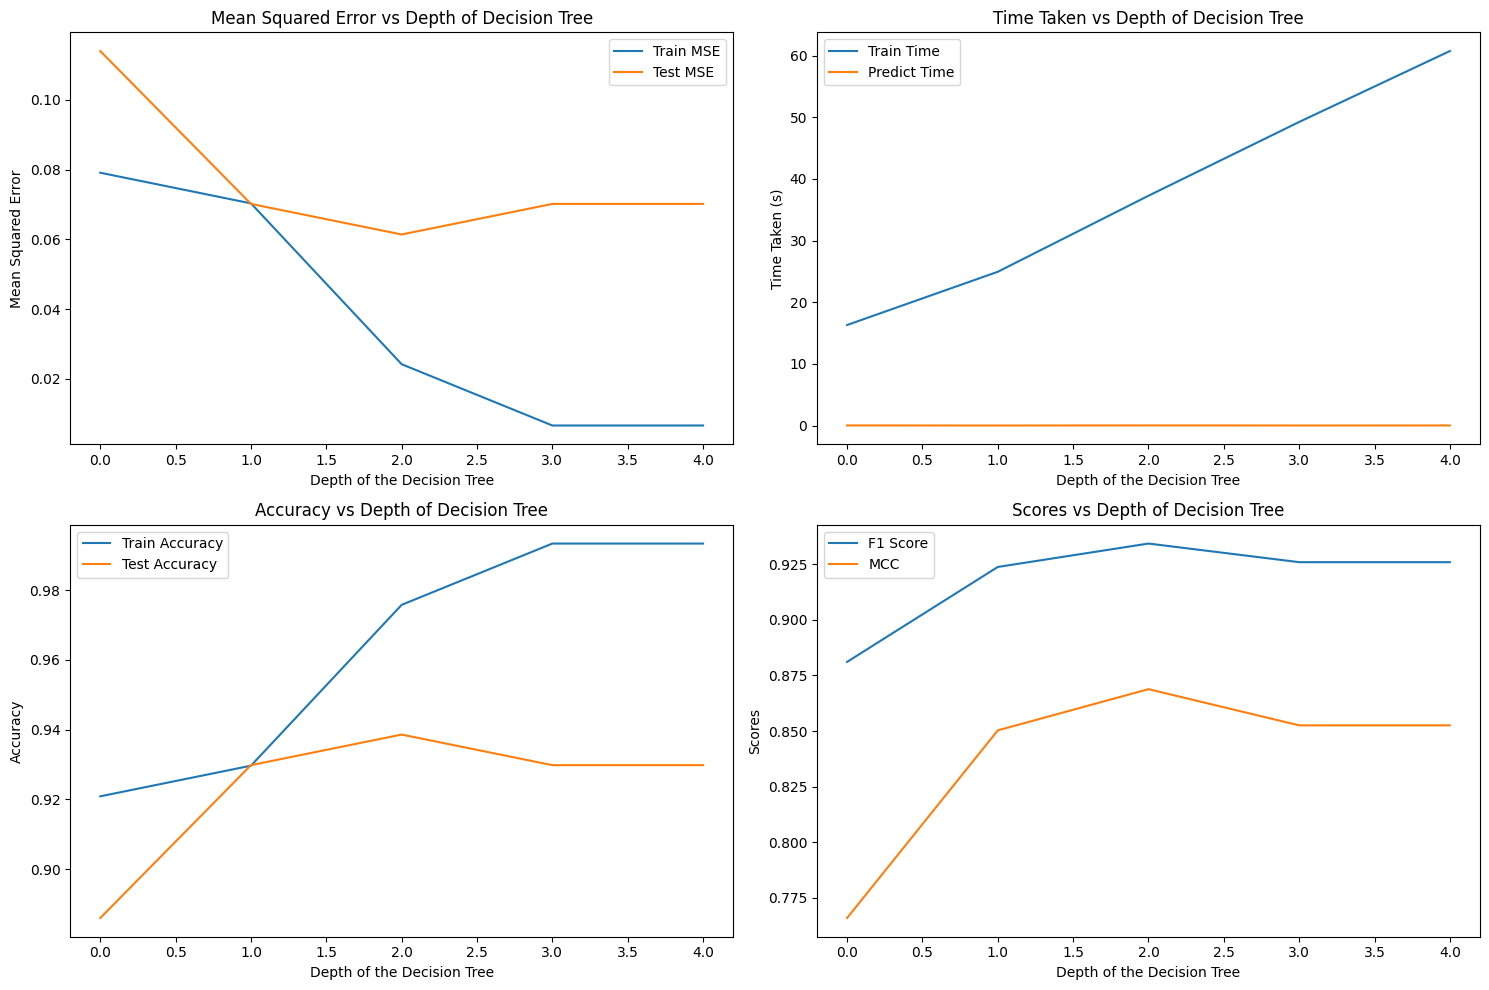

In [22]:
# Plotting the metrics
if type == 'classification':
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    Metrics.iloc[:, :2].plot(ax=axs[0, 0])
    axs[0, 0].set_xlabel('Depth of the Decision Tree')
    axs[0, 0].set_ylabel('Mean Squared Error')
    axs[0, 0].set_title('Mean Squared Error vs Depth of Decision Tree')

    Metrics.iloc[:, 2:4].plot(ax=axs[0, 1])
    axs[0, 1].set_xlabel('Depth of the Decision Tree')
    axs[0, 1].set_ylabel('Time Taken (s)')
    axs[0, 1].set_title('Time Taken vs Depth of Decision Tree')

    Metrics.iloc[:, 4:6].plot(ax=axs[1, 0])
    axs[1, 0].set_xlabel('Depth of the Decision Tree')
    axs[1, 0].set_ylabel('Accuracy')
    axs[1, 0].set_title('Accuracy vs Depth of Decision Tree')

    Metrics.iloc[:, 6:].plot(ax=axs[1, 1])
    axs[1, 1].set_xlabel('Depth of the Decision Tree')
    axs[1, 1].set_ylabel('Scores')
    axs[1, 1].set_title('Scores vs Depth of Decision Tree')

elif type == 'regression':
    fig, axs = plt.subplots(1, 2, figsize=(20, 8))

    Metrics.iloc[:, :2].plot(ax=axs[0])
    axs[0].set_xlabel('Depth of the Decision Tree')
    axs[0].set_ylabel('Mean Squared Error')
    axs[0].set_title('Mean Squared Error vs Depth of Decision Tree')

    Metrics.iloc[:, 2:4].plot(ax=axs[1])
    axs[1].set_xlabel('Depth of the Decision Tree')
    axs[1].set_ylabel('Time Taken (s)')
    axs[1].set_title('Time Taken vs Depth of Decision Tree')
    
plt.tight_layout()
plt.show()